#TS-CausalNN: Learning Temporal Causal Relations from Non-linear Non-stationary Time Series Data (TKE Dataset)


This notebook contains the proposed TS-CausalNN model. Here we have developed the proposed Causal Conv2D layer and the optimization function.

The functions to visualize the predicted causal graph are available after the model training codes. The predicted graph is compared with ground truth using an adjacency matrix (array).   

In this notebook, we applied the proposed model to the TKE dataset to generate a full causal graph and summary graph.

In [2]:
import numpy as np
import pandas as pd


In [42]:
!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=ca7986c3c0d3d0232367986a37ce662a4971670d6c661d4ffea58b26435182d1
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=d267b6c42026d4b2bdff8fee1ca37c10a162de7e5caa177407538b49f468f69a
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [43]:
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [4]:
df_2D_data_TKE = pd.read_csv('/content/TKE_data.csv')
#df_2D_data_TKE = df_2D_data_TKE.drop('Unnamed: 0', axis=1)
df_2D_data_TKE

,CSP_TKE_SH,CSP_TKE_BU,CSP_TKE,CSP_TKE_TEND
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,-5.481064e-12,2.893937e-09,-5.481064e-12
2,-2.872043e-11,9.935044e-11,1.174000e-08,4.190957e-11
3,-2.279047e-11,1.211548e-10,1.449416e-08,7.557389e-11
4,5.889356e-12,1.926259e-11,1.389811e-08,3.104130e-11
...,...,...,...,...
776,7.286902e-06,-3.130422e-06,3.017054e-02,1.144338e-05
777,7.371270e-06,1.325219e-06,2.996980e-02,1.606776e-05
778,5.797465e-06,5.157365e-06,3.026166e-02,1.675229e-05
779,2.389570e-06,7.089153e-06,3.061606e-02,1.186829e-05


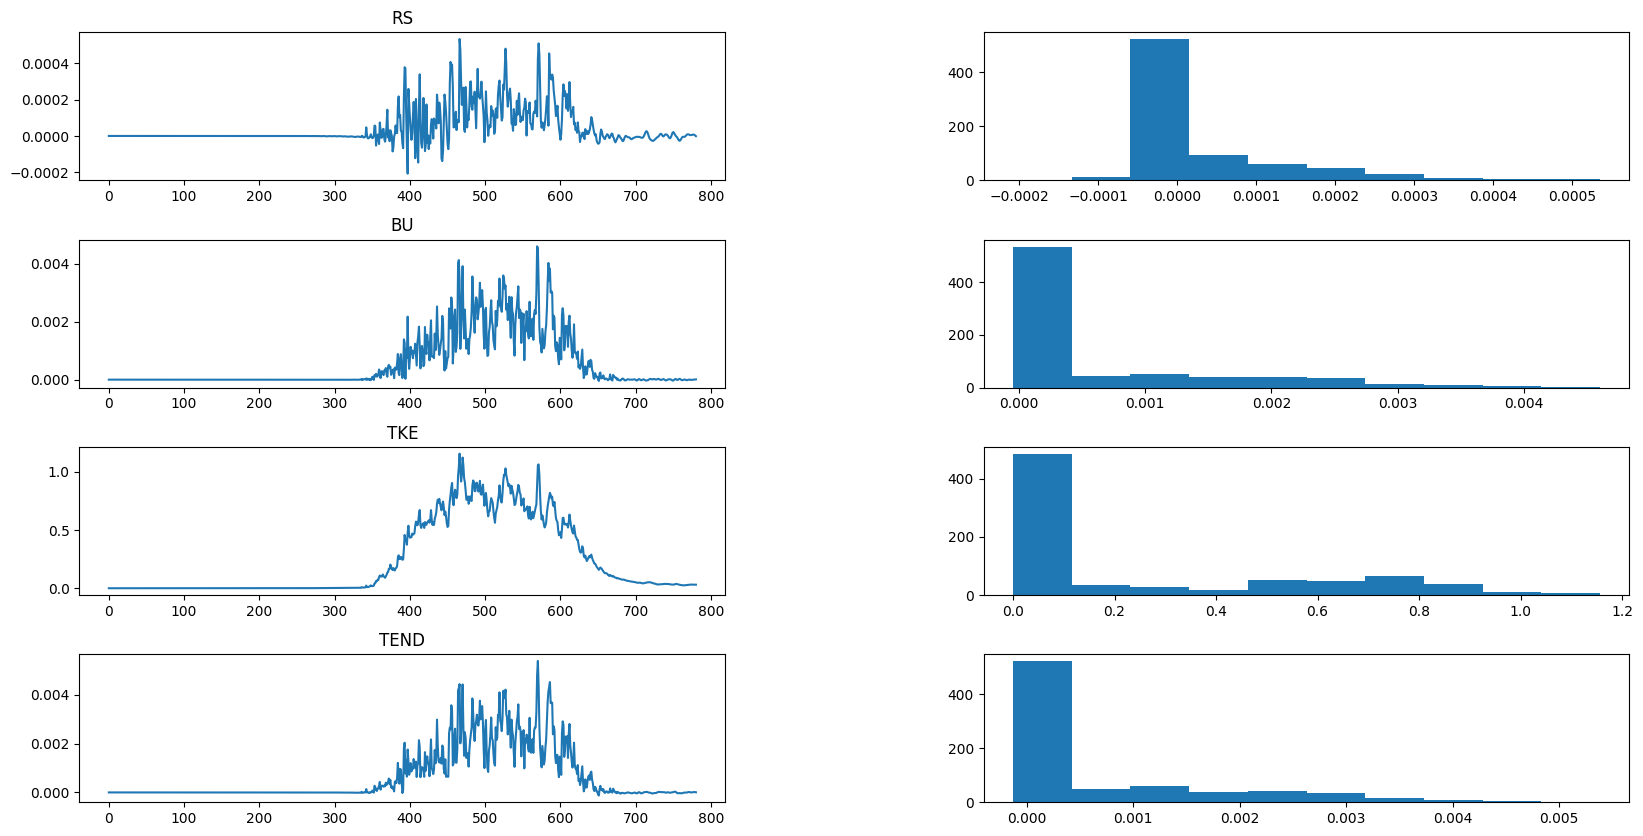

In [6]:
from matplotlib import pyplot
series_CSP_TKE_SH = df_2D_data_TKE['CSP_TKE_SH']
series_CSP_TKE_BU = df_2D_data_TKE['CSP_TKE_BU']
series_CSP_TKE = df_2D_data_TKE['CSP_TKE']
series_CSP_TKE_TEND = df_2D_data_TKE['CSP_TKE_TEND']


fig, ax = pyplot.subplots(nrows=4, ncols=2, figsize=(20, 10),
                       gridspec_kw={
                       'wspace': 0.4,
                       'hspace': 0.4})

# line plot and histogram
ax[0][0].plot(series_CSP_TKE_SH)
ax[0][0].set_title('RS')
ax[0][1].hist(series_CSP_TKE_SH)

ax[1][0].plot(series_CSP_TKE_BU)
ax[1][0].set_title('BU')
ax[1][1].hist(series_CSP_TKE_BU)

ax[2][0].plot(series_CSP_TKE)
ax[2][0].set_title('TKE')
ax[2][1].hist(series_CSP_TKE)

ax[3][0].plot(series_CSP_TKE_TEND)
ax[3][0].set_title('TEND')
ax[3][1].hist(series_CSP_TKE_TEND)


pyplot.show()

#Data Pre-processing

In [7]:
df_2D_data_TKE_nz = df_2D_data_TKE.iloc[300:]
df_2D_data_TKE_NZ = df_2D_data_TKE_nz[[ "CSP_TKE_SH", "CSP_TKE_BU", "CSP_TKE_TEND", "CSP_TKE"]]

In [8]:
import numpy as np
import pandas as pd

def data_preprocessing(data, max_lag=5):
  from sklearn.preprocessing import MinMaxScaler

  #convert to numpy array
  syn_data_np = data.to_numpy()

  #normalize the dataset
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  syn_data_np_nor = scaler_X.fit_transform(syn_data_np)
  syn_data_np = syn_data_np_nor

  #transform into 2D data
  syn_data_np_T= syn_data_np.T
  syn_data_pro = np.zeros((syn_data_np.shape[0]-max_lag,syn_data_np.shape[1],(max_lag+1)))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    syn_data_pro[i,:,:]= syn_data_np_T[:, i:i+(max_lag+1)]
  syn_data_2d = np.expand_dims(syn_data_pro, axis =-1)

  #make datafrom with normalized data
  syn_data_nor_df =pd.DataFrame(data = syn_data_np,
                  columns = data.columns)

  #transform normalized data into 1D shape with lagged and current time values
  size_1d = syn_data_np.shape[1]*(max_lag+1)
  print(size_1d)
  syn_data_1d = np.zeros((syn_data_np.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np.shape[1]
      syn_data_1d[i,j_end:j_end+syn_data_np.shape[1]]= syn_data_np[i+j, :]

  #transform non-normalized data into 1D shape with lagged and current time values
  syn_data_np_2 = data.to_numpy()
  syn_data_1d_not_norm = np.zeros((syn_data_np_2.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np_2.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np_2.shape[1]
      syn_data_1d_not_norm[i,j_end:j_end+syn_data_np_2.shape[1]]= syn_data_np_2[i+j, :]


  return syn_data_np_nor, syn_data_2d, syn_data_nor_df, syn_data_1d,  syn_data_1d_not_norm

In [9]:
TKE_NZ_np_nor, TKE_NZ_2d, TKE_NZ_df, TKE_NZ_1d, TKE_NZ_1d_not_norm = data_preprocessing(df_2D_data_TKE_NZ, max_lag=5)

24


In [10]:
TKE_NZ_np_nor.shape

(481, 4)

In [11]:
TKE_NZ_2d.shape

(476, 4, 6, 1)

In [12]:
TKE_NZ_df.shape

(481, 4)

In [13]:
data_y_TKE_NZ = TKE_NZ_np_nor[5:,:]
data_y_TKE_NZ.shape

(476, 4)

# Proposed TS-CausalNN Model

In [14]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D, Conv1D, AveragePooling1D, LeakyReLU
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
import keras.backend as K
import tensorflow as tf
from keras.layers import concatenate
from keras.regularizers import l1, l2
from time import time

keras.utils.set_random_seed(1001)

In [16]:
class CausalConv2D(tf.keras.layers.Layer):
    def __init__(self, num_outputs, counter, *args, **kwargs):
        super(CausalConv2D, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(*args, **kwargs)
        self.num_outputs = num_outputs
        self.counter = counter

    def build(self, input_shape):
        self.W=self.add_weight(name='kernel',
                           shape=(input_shape[1], input_shape[2],input_shape[3], 1),
                           #initializer = keras.initializers.RandomUniform(minval=0.05, maxval=0.5),
                           initializer = (tf.keras.initializers.glorot_uniform(seed=8)),
                           trainable=True)
        self.mask = np.ones(shape=self.W.shape)
        #self.W = self.W * -1
        print(self.W)
        self.mask[self.counter,(input_shape[2]-1),...] = 0.0

    def get_weights(self):
        return super().get_weights()

    def call(self, inputs):
        self.W.assign(tf.math.multiply(self.W, self.mask))
        return self.conv2d.convolution_op(inputs, self.W)

In [17]:
# 2D
def get_model_2d(input_dims):
    input_batch = Input(shape = input_dims)

    conv_model = Sequential()
    conv_model = Conv2D(filters=4, kernel_size=1, strides=(1,1), padding='valid', activation="linear", name='conv1')(input_batch)
    conv_model = tf.math.reduce_mean(conv_model, axis=-1)
    conv_model = Reshape((4, 6, 1))(conv_model)
    pooled_outputs = []
    for i in range(0, 4):
      layer = CausalConv2D(filters=1, kernel_size=(4,6), num_outputs=1, counter=i, padding='valid', activation="tanh",)(conv_model)
      pooled_outputs.append(layer)
    output = concatenate(pooled_outputs)
    output = Flatten()(output)

    model = Model(inputs=input_batch, outputs=output, name='cpred')

    return model

In [18]:
class CausalNNModel(object):
    def __init__(self,
                 dims,
                 alpha=0.0,
                 rho = 1.0,
                 rho_max = 10e20,
                 h_tol = 1e-8,
                 init='glorot_uniform'):

        super(CausalNNModel, self).__init__()

        self.dims = dims
        self.n_stacks = len(self.dims) - 1
        self.alpha = alpha
        self.rho = rho
        self.h_p = np.Inf
        self.rho_max = rho_max
        self.h_tol = h_tol
        self.model_2d = get_model_2d(self.dims)
        print("====Model created=====")

        self.model = Model(inputs=self.model_2d.input, outputs=self.model_2d.output)


    def custom_loss_function(self, y_true, y_pred):
      mse = keras.losses.mean_squared_error(y_true, y_pred)
      h_val = self.causal_loss_h()
      h_loss = 0.5 * self.rho * h_val * h_val + self.alpha * h_val
      lambda1 = 0.1
      adj_mat = self.get_mat()
      sparse_loss = lambda1 * tf.math.reduce_sum(tf.abs(adj_mat))
      print('MSE Loss is: {}, h Loss is: {}, L1 loss: {}, Total Loss is: {}'.format(tf.reduce_mean(mse), h_loss, sparse_loss, tf.reduce_mean(mse)+h_loss))
      return mse + h_loss + sparse_loss 

    def causal_loss_h(self):
      mat = self.get_mat()
      h_val = self.h_acy_1(mat[:, 20:])
      return h_val

    def get_mat(self):
      #w1_2d_s = self.model.get_layer(index=-7).get_weights()
      w2_2d_s = self.model.get_layer(index=-6).get_weights()
      w3_2d_s = self.model.get_layer(index=-5).get_weights()
      w4_2d_s = self.model.get_layer(index=-4).get_weights()
      w5_2d_s = self.model.get_layer(index=-3).get_weights()
      #arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr2_2d_s = np.expand_dims(np.squeeze(np.array(w2_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr3_2d_s = np.expand_dims(np.squeeze(np.array(w3_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr4_2d_s = np.expand_dims(np.squeeze(np.array(w4_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr5_2d_s = np.expand_dims(np.squeeze(np.array(w5_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      mat_2d_s = np.concatenate(( arr2_2d_s, arr3_2d_s, arr4_2d_s, arr5_2d_s))
      #print(mat_2d_s)
      return mat_2d_s

    def h_acy_1(self, A):
      n_var = A.shape[0]
      h = tf.linalg.trace(tf.linalg.expm(A * A)) - n_var
      return h


    def h_acy(self, A):
      '''Calculate the constraint of A ensure that it's a DAG'''
      n_var = A.shape[0]
      M = tf.eye(n_var, num_columns = n_var) + A/n_var
      E = M
      for _ in range(n_var - 2):
        E = tf.linalg.matmul(E, M)
      h = tf.math.reduce_sum(tf.transpose(E) * M) - n_var
      return h

    def compile(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss= self.custom_loss_function) # ['mse', self.causal_loss()])

    def fit(self, x, y=None, maxiter=100, batch_size=512, save_dir='./results/temp'):
        t1 = time()

        # logging file
        import csv
        logfile = open(save_dir + '/causalnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()
        train_loader = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        optimizer = tf.keras.optimizers.Adam(1e-2)
        w1_2d_s = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)


        for epoch in range(int(maxiter)):
          print('Epoch: {}', epoch)
          h_n = None
          for (x, y) in train_loader:
            #eval loss and compute gradients
            with tf.GradientTape() as tape:
              tape.watch(self.model.trainable_variables)
              #passing through neural network
              output = self.model(x)
              #calculate loss
              loss = self.custom_loss_function(y, output)
              gradients = tape.gradient(loss, self.model.trainable_variables)
              optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
              h_n = self.causal_loss_h()

          if h_n > 0.25 * self.h_p:
                self.rho = self.rho*1.1
          self.h_p = h_n
          print('New h_val is :', h_n)
          self.alpha += self.rho * self.h_p

          if self.h_p <= self.h_tol or self.rho >= self.rho_max:
            print('Before the loop end # h_val is: {}, rho is: {}'.format(self.h_p, self.rho))
            break

        # save the trained model
        logfile.close()
        file_name  = "/CausalNN_model_final_" + str(round(time()))+ ".h5"
        print('saving model to:', save_dir + file_name)
        self.model.save_weights(save_dir + file_name)

        w1_2d_s_1 = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s_1 = np.expand_dims(np.squeeze(np.array(w1_2d_s_1), axis=(0,3,4)).flatten('F'), axis=0)

        y_pred = self.model.predict(x)
        adj_mat = self.get_mat()

        print('The conv layer 1 weights before training :', arr1_2d_s)
        print('The conv layer 1 weights after training :', arr1_2d_s_1)

        return y_pred, adj_mat

#Model creation and training:

In [19]:
keras.utils.set_random_seed(1001)

cnnmodel = CausalNNModel(dims=TKE_NZ_2d.shape[1:])

<tf.Variable 'causal_conv2d/kernel:0' shape=(4, 6, 1, 1) dtype=float32, numpy=
array([[[[ 0.01729116]],

        [[ 0.05369946]],

        [[-0.11558445]],

        [[-0.1930318 ]],

        [[-0.22727013]],

        [[-0.10506889]]],


       [[[-0.03241783]],

        [[ 0.34967968]],

        [[-0.22822307]],

        [[ 0.18624505]],

        [[-0.03919902]],

        [[-0.03960952]]],


       [[[ 0.20739552]],

        [[-0.14644605]],

        [[ 0.21469983]],

        [[-0.17902574]],

        [[ 0.06509387]],

        [[ 0.17076865]]],


       [[[ 0.21393666]],

        [[-0.3412853 ]],

        [[ 0.0880048 ]],

        [[-0.3153036 ]],

        [[-0.07369781]],

        [[ 0.15640828]]]], dtype=float32)>
<tf.Variable 'causal_conv2d_1/kernel:0' shape=(4, 6, 1, 1) dtype=float32, numpy=
array([[[[ 0.01729116]],

        [[ 0.05369946]],

        [[-0.11558445]],

        [[-0.1930318 ]],

        [[-0.22727013]],

        [[-0.10506889]]],


       [[[-0.03241783]],

        [

In [20]:
cnnmodel.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 6, 1)]            0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 4, 6, 4)              8         ['input_1[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 4, 6)                 0         ['conv1[0][0]']               
 ambda)                                                                                           
                                                                                                  
 reshape (Reshape)           (None, 4, 6, 1)              0         ['tf.math.reduce_mean[0][0

In [21]:
cnnmodel.compile()

In [ ]:
y_pred, mat = cnnmodel.fit(x=TKE_NZ_2d, y=data_y_TKE_NZ, maxiter=25, batch_size=16, save_dir='/content/')

Epoch: {} 0
MSE Loss is: 0.02199643850326538, h Loss is: 1.003495640361507e-06, L1 loss: 1.4565690755844116, Total Loss is: 0.021997442469000816
MSE Loss is: 0.021093592047691345, h Loss is: 1.1373878123777104e-06, L1 loss: 1.4486992359161377, Total Loss is: 0.021094730123877525
MSE Loss is: 0.02111770212650299, h Loss is: 8.269363434010302e-07, L1 loss: 1.444407343864441, Total Loss is: 0.02111852914094925
MSE Loss is: 0.026190372183918953, h Loss is: 5.683996278094128e-07, L1 loss: 1.4397001266479492, Total Loss is: 0.02619094029068947
MSE Loss is: 0.036225613206624985, h Loss is: 3.9458075207221555e-07, L1 loss: 1.4348949193954468, Total Loss is: 0.03622600808739662
MSE Loss is: 0.10198137164115906, h Loss is: 2.9176635507610627e-07, L1 loss: 1.432694673538208, Total Loss is: 0.10198166221380234
MSE Loss is: 0.11362171918153763, h Loss is: 2.3247821445693262e-07, L1 loss: 1.4340654611587524, Total Loss is: 0.11362195014953613
MSE Loss is: 0.10354728251695633, h Loss is: 2.0019444946

In [ ]:
mat.shape

(4, 24)

Convert the predicted adjacency for visualization as a table.

In [ ]:
mat_df_2d_s = pd.DataFrame(mat)

In [ ]:
mat_f_df = pd.DataFrame(mat).T

In [ ]:
mat_df_2d_s.T

,0,1,2,3,4
0,0.267141,-0.069342,0.030890,0.282325,-0.003135
1,-0.115642,0.585743,-0.148666,-0.116705,-0.201911
2,-0.188006,-0.224313,-0.016974,-0.197734,0.018553
3,0.443026,0.106543,0.206775,0.458210,0.172750
4,-0.335194,-0.527397,-0.184580,-0.344805,-0.130836
5,0.322952,-0.027866,0.105894,0.338318,0.065592
6,0.139681,0.666886,0.141579,0.137449,0.071939
7,-0.322354,-0.324406,-0.112589,-0.328732,-0.119155
8,-0.030332,-0.381151,-0.247391,-0.014968,-0.287693
9,0.031038,-0.190260,0.225490,0.023840,0.236185


#Full Causal Graph

In [22]:
mat = np.genfromtxt('/content/proposed-full-adj-mat_TKE_4.csv', delimiter=',')

In [23]:
matrix_2d_2d_s = mat

In [ ]:
np.savetxt('/content/proposed-full-adj-mat_TKE_4.csv', matrix_2d_2d_s, delimiter=",")

In [24]:
import networkx as nx
G_2d = nx.DiGraph()

nodes_2d = [ "SH(t-5)", "BU(t-5)", "TEND(t-5)", "TKE(t-5)",
             "SH(t-4)", "BU(t-4)", "TEND(t-4)", "TKE(t-4)",
            "SH(t-3)", "BU(t-3)", "TEND(t-3)", "TKE(t-3)",
             "SH(t-2)", "BU(t-2)",  "TEND(t-2)", "TKE(t-2)",
             "SH(t-1)", "BU(t-1)", "TEND(t-1)", "TKE(t-1)",
               "SH(t)",   "BU(t)",   "TEND(t)",  "TKE(t)"  ]
nodes_r_2d=[ "SH(t)", "BU(t)",  "TEND(t)", "TKE(t)"]
pred_graph_f = np.zeros((4,24))

In [25]:
for i in range (0, 24):
  G_2d.add_node(nodes_2d[i],pos=(int(i/4)+1,(i%4)+1))

In [26]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.25:
      col = np.round(matrix_2d_2d_s[j,i], 2)
      print(i,j)
      G_2d.add_edge(nodes_2d[i], nodes_r_2d[j], weight=col)
      pred_graph_f[j,i]=1


2 0
5 0
5 1
5 2
5 3
10 0
10 3
13 1


In [27]:
pos_2d=nx.get_node_attributes(G_2d,'pos')
pos_2d

{'SH(t-5)': (1, 1),
 'BU(t-5)': (1, 2),
 'TEND(t-5)': (1, 3),
 'TKE(t-5)': (1, 4),
 'SH(t-4)': (2, 1),
 'BU(t-4)': (2, 2),
 'TEND(t-4)': (2, 3),
 'TKE(t-4)': (2, 4),
 'SH(t-3)': (3, 1),
 'BU(t-3)': (3, 2),
 'TEND(t-3)': (3, 3),
 'TKE(t-3)': (3, 4),
 'SH(t-2)': (4, 1),
 'BU(t-2)': (4, 2),
 'TEND(t-2)': (4, 3),
 'TKE(t-2)': (4, 4),
 'SH(t-1)': (5, 1),
 'BU(t-1)': (5, 2),
 'TEND(t-1)': (5, 3),
 'TKE(t-1)': (5, 4),
 'SH(t)': (6, 1),
 'BU(t)': (6, 2),
 'TEND(t)': (6, 3),
 'TKE(t)': (6, 4)}

In [28]:
weights_2d = nx.get_edge_attributes(G_2d,'weight').values()

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
<ipython-input-29-c15bca5e6666>:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.25, 1), cmap=plt.cm.tab20),


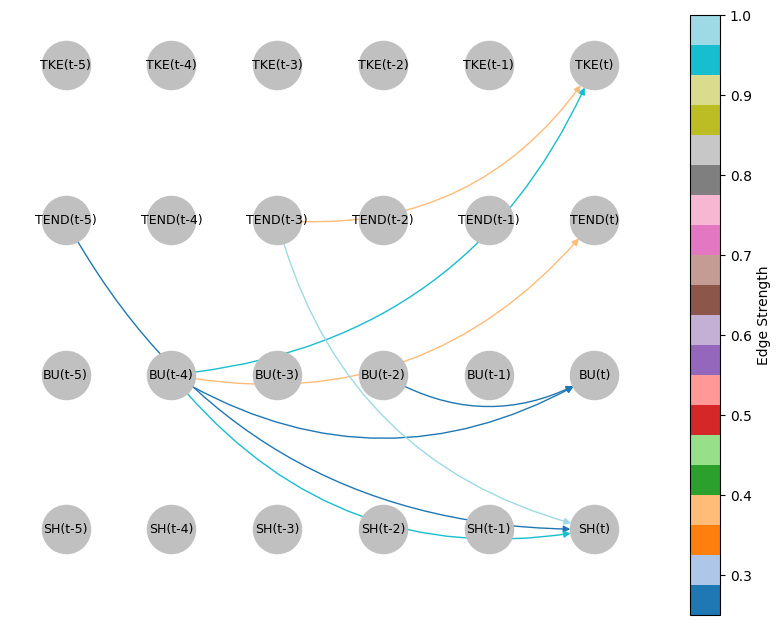

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(8, 6))
nx.draw(G_2d, pos_2d, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20,
        font_size=9, node_size=1200, node_color='#c0c0c0',
        edge_color=weights_2d, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.25, 1), cmap=plt.cm.tab20),
              orientation='vertical', label='Edge Strength')
plt.show()

#Summary Causal Graph

In [30]:
matrix_2d_2d_s = mat

In [34]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s = [ "SH", "BU", "TEND", "TKE" ]
nodes_r_2d_s = [ "SH", "BU", "TEND", "TKE" ]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [35]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s[i],pos=(int(i/2)+1,(i%2)+1))

In [36]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.25:
      col = np.round(matrix_2d_2d_s[j,i], 2)
      print(i,j, matrix_2d_2d_s[j,i])
      G_2d_s1.add_edge(nodes_2d_s[i%4], nodes_r_2d_s[j],  weight=col)
      pred_graph_s1[i%4, j]=1


2 0 0.25495898723602295
5 0 0.37172502279281616
5 1 0.2506660521030426
5 2 0.2654227912425995
5 3 0.3670382797718048
10 0 0.37995970249176025
10 3 0.2736373245716095
13 1 0.25301846861839294


In [37]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'SH': (1, 1), 'BU': (1, 2), 'TEND': (2, 1), 'TKE': (2, 2)}

In [38]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

<ipython-input-39-f6e0a9aa8a75>:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.25, 1), cmap=plt.cm.tab20),


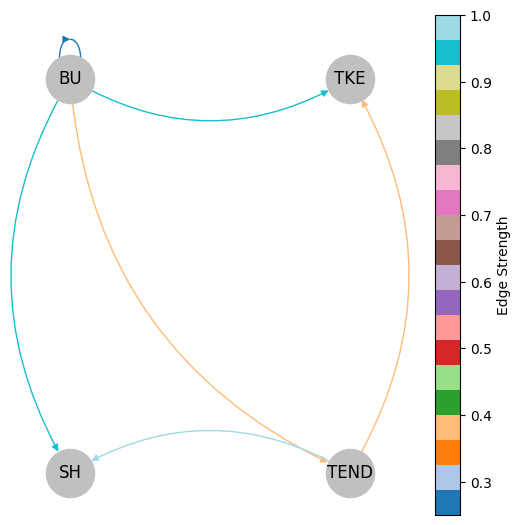

In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(5, 5))
nx.draw(G_2d_s1, pos_2d_s1,  edge_cmap= plt.cm.tab20,  #cmap = plt.get_cmap('jet'),
        font_size=12, node_size=1200, node_color='#c0c0c0', #[30,30,30,30,30],
        edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.25, 1), cmap=plt.cm.tab20),
              orientation='vertical', label='Edge Strength')
plt.show()

In [40]:
pred_graph_s1

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [45]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

5.0

In [46]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.6875, Precision: 0.3333333333333333, Recall: 0.6666666666666666, FDR: 0.6666666666666666, F1 Score: 0.4444444444444444


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_graph.reshape(-1), pred_graph_s1.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.6875
Precision: 0.3333333333333333
Recall (Sensitivity): 0.6666666666666666
F1-Score: 0.4444444444444444


# Ground Truth

In [44]:
true_graph = np.zeros((4,4)) # [ "SH", "BU", "TEND", "TKE" ]
true_graph[0,2]=1
true_graph[1,2]=1
true_graph[2,3]=1
true_graph

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [ ]:
matrix_2d_2d_s = true_graph

In [ ]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s = [ "SH", "BU", "TEND", "TKE" ]
nodes_r_2d_s = [ "SH", "BU", "TEND", "TKE" ]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
for i in range(0, 4):
  for j in range (0, 4):
    if matrix_2d_2d_s[i,j] > 0.25:
      col = np.round(matrix_2d_2d_s[i,j], 2)
      print(i,j, matrix_2d_2d_s[j,i])
      G_2d_s1.add_edge(nodes_2d_s[i%4], nodes_r_2d_s[j],  weight=col)
      pred_graph_s1[i%4, j]=1


0 2 0.0
1 2 0.0
2 3 0.0


In [ ]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'SH': (1, 1), 'BU': (1, 2), 'TEND': (2, 1), 'TKE': (2, 2)}

In [ ]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

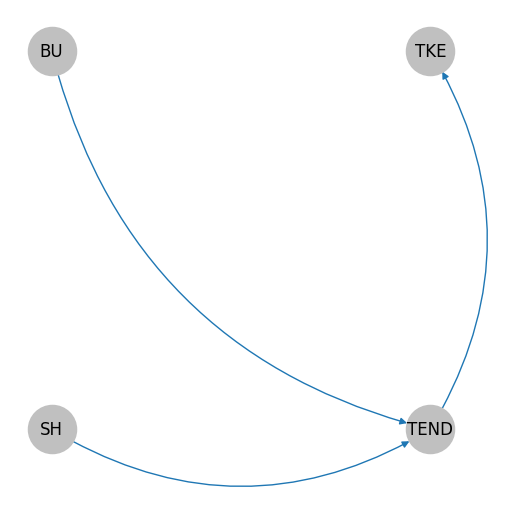

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(5, 5))
nx.draw(G_2d_s1, pos_2d_s1,  edge_cmap= plt.cm.tab20,  #cmap = plt.get_cmap('jet'),
        font_size=12, node_size=1200, node_color='#c0c0c0', #[30,30,30,30,30],
        edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
#plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.25, 1), cmap=plt.cm.tab20),
#              orientation='vertical', label='Edge Strength')
plt.show()

#Non-stationarity test

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_2D_data_TKE_NZ.describe()

,CSP_TKE_SH,CSP_TKE_BU,CSP_TKE_TEND,CSP_TKE
count,481.000000,481.000000,4.810000e+02,481.000000
mean,0.000069,0.000917,1.055719e-03,0.378960
std,0.000114,0.001060,1.223132e-03,0.330891
min,-0.000208,-0.000044,-1.278639e-04,0.001737
25%,-0.000005,0.000008,3.265568e-07,0.046638
50%,0.000017,0.000458,6.263948e-04,0.282823
75%,0.000129,0.001620,1.859171e-03,0.676280
max,0.000535,0.004600,5.385920e-03,1.156765


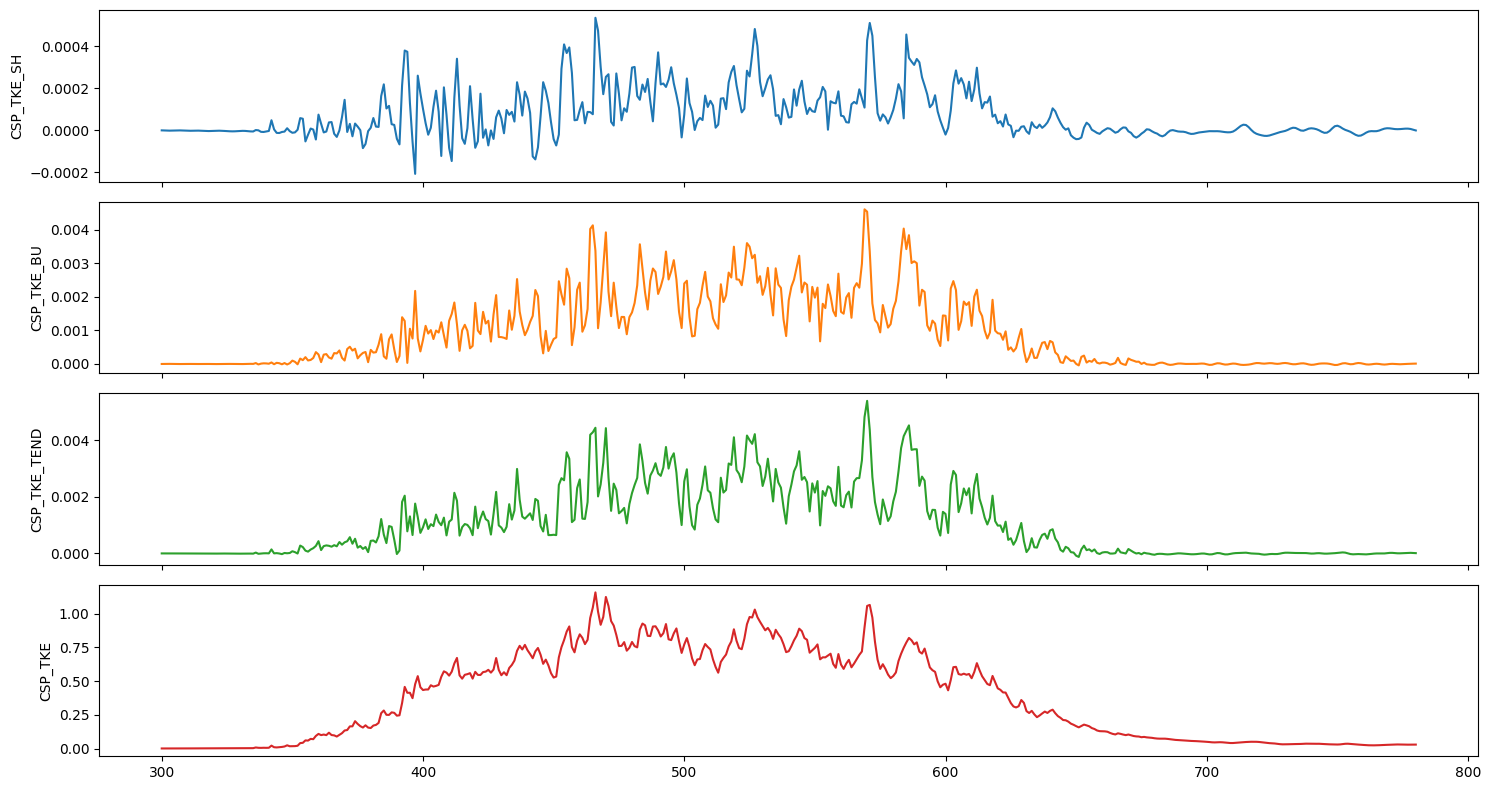

In [ ]:
fig,ax = plt.subplots(4, figsize=(15,8), sharex=True)
plot_cols = ["CSP_TKE_SH", "CSP_TKE_BU", "CSP_TKE_TEND",  "CSP_TKE"]
df_2D_data_TKE_NZ[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)):
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

####ADF Test for Stationarity

Null hypothesis: The time series has a unit root and is not stationary.

If failed to be rejected, it suggests the time series is not stationarity.

If p-values is higher than 0.05 alpha level, we cannot reject the null hypothesis. So the time series is not stationary.

In [ ]:
#ADF Test for non-stationarity
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    stationary = []
    for c in data_df.columns:
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
        if adf_res[1] > 0.05:
          stationary.append('No')
        else:
          stationary.append('Yes')
    adf_res_df = pd.DataFrame({'Test statistic': test_stat,
                               'p-value': p_val,
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct,
                               'Stationary': stationary},
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [ ]:
adf_test(df_2D_data_TKE_NZ)

,CSP_TKE_SH,CSP_TKE_BU,CSP_TKE_TEND,CSP_TKE
Test statistic,-1.906424,-1.079248,-1.223361,-1.389193
p-value,0.329045,0.723276,0.663466,0.587446
Critical value - 1%,-3.444553,-3.444553,-3.444522,-3.444105
Critical value - 5%,-2.867803,-2.867803,-2.867789,-2.867606
Critical value - 10%,-2.570106,-2.570106,-2.570099,-2.570001
Stationary,No,No,No,No


#### KPSS Test for Stationary

Null hypothesis: The time series is stationary.

If the p-value is less than 0.05 alpha level, we can reject the null hypothesis and derive that the time series is not stationary.

In [ ]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    stationary = []
    for c in data_df.columns:
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
        if kpss_res[1] > 0.05:
          stationary.append('Yes')
        else:
          stationary.append('No')
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat,
                               'p-value': p_val,
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct,
                               'Stationary': stationary},
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [ ]:
kpss_test(df_2D_data_TKE_NZ)

,CSP_TKE_SH,CSP_TKE_BU,CSP_TKE_TEND,CSP_TKE
Test statistic,0.72923,0.826745,0.816025,0.867482
p-value,0.01,0.01,0.01,0.01
Critical value - 1%,0.216,0.216,0.216,0.216
Critical value - 2.5%,0.176,0.176,0.176,0.176
Critical value - 5%,0.146,0.146,0.146,0.146
Critical value - 10%,0.119,0.119,0.119,0.119
Stationary,No,No,No,No
